In [1]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

Skipping install of 'rwwa' from a github remote, the SHA1 (88fa2f80) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Loading required package: plyr


Attaching package: ‘plyr’


The following object is masked from ‘package:distillery’:

    is.formula




# Trend fitting - observations

## Univariate analysis

In [2]:
datasets <- c("acp-filled-allstations-1979", "acp-filled-allstations-1950", "acp-filled-allstations-1925", "acp-filled-allstations-1900", "acp-filled-allstations-1881")
datasets <- c("chirps","era5land", "era5land-1979-2021", "mswep", "acp-filled-allstations")
datasets <- c("acp-filled-subset-1979", "acp-filled-subset-1950", "acp-filled-subset-1925", "acp-filled-subset-1900", "acp-filled-subset-1881")

### Fit models

In [3]:
# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [4]:
nsamp <- 1000
for (ds in datasets) {
    
    fnm <- paste0("ts/panama_pr-rs_",ds,".dat")
    
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        res <- boot_ci(mdl, cov_f = cov_2023, cov_cf = cov_cf, nsamp = nsamp)
        
        # get correlation between Nino3.4 and rainy season precip, for evaluation
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
                                                   
        write.csv(rbind(res, nino_corr), res_fnm)
    }
}

### Compile results for synthesis

In [68]:
obs_res <- data.frame(t(sapply(datasets, function(ds) {
    res <- read.csv(paste0("res/res_panama_pr-rs_",ds,".csv"), row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
})))

In [70]:
# select the critical columns & save as a single .csv
write.csv(obs_res[,rowSums(sapply(c("disp", "nino.corr", "event.magnitude_est","return.period", "PR", "dI.rel"), grepl, colnames(obs_res))) == 1],
          "res_pr-rs_gmst-nino_obs.csv")

### Plots of fitted trends - compare datasets

In [26]:
datasets <- c("chirps","era5land-1979-2021", "mswep", "acp-filled-allstations")
nobs <- length(datasets)


# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [5]:
prep_window(c(1,nobs))
png("fig/obs-res_fitted-trend-1979-2023.png", h = 480, w = 480*nobs); par(cex = 2, cex.main = 2.5, cex.lab = 2, cex.axis = 1.5); {
    par(mfrow = c(1,nobs), lwd = 2, mar = c(5.1, 5.1, 4.1, 2.1))
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev <- NA } else { ev <- mdl$ev }

        plot(df$year+0.5, df$pr, type = "S", col = adjustcolor("black", 0.4), xlim = c(1979, 2023), ylim = c(1500,3500), xlab = "Year", ylab = "Rainy season precipitation (mm)", main = toupper(ds))
        lines(df$year, ns_pars(mdl)$loc, lwd = 2)
        lines(df$year, eff_return_level(mdl, 40), col = "blue", lwd = 2)
        points(2023, ev, pch = 0, col = "magenta", lwd = 2, cex = 3)
        
        # lines(df$year, fitted(loess(pr ~ year, df)), col = "red")
        
        legend("topleft", legend = c("Mean", "1-in-40-year event"), lty = 1, col = c("black", "blue"), lwd = 4, cex = 2)
    }
}; dev.off()

png 
  2

In [42]:
nsamp = 1000
prep_window(c(2,nobs))
png("fig/obs-res_covariate-trend-1979-2023.png", h = 480*2, w = 480*nobs); par(cex = 2, cex.main = 2.5, cex.lab = 2, cex.axis = 1.5); {
    par(mfrow = c(2,nobs), lwd = 2, mar = c(5.1, 5.1, 4.1, 2.1))
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev_x <- 9999 } else { ev_x <- NA }

        plot_covtrend(mdl, xcov = "gmst", main = toupper(ds), ci_cov = data.frame(gmst = c("now" = 0, "hist" = -1.2), nino = mean(df$nino)), ylim = c(1500,3500), ev_x = ev_x, ylab = "Rainy season precipitation (mm)", nsamp = nsamp)
    }
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev_x <- 9999 } else { ev_x <- NA }

        plot_covtrend(mdl, xcov = "nino", plot_cov = data.frame(gmst = mean(df$gmst), nino = df$nino), ci_cov = data.frame(gmst = mean(df$gmst), nino = c("pos" = 1, "now" = cov_2023$nino, "neut" = 0)), 
                      main = toupper(ds), ylim = c(1500,3500), ev_x = ev_x, ylab = "Rainy season precipitation (mm)", nsamp = nsamp)
        abline(v = 0, lty = 2, lwd = 0.5)
    }
}; dev.off()

png 
  2

In [15]:
prep_window(c(1,nobs))
png("fig/obs-res_rl-plots-hist-1979-2023.png", h = 480, w = 480*nobs); par(cex = 2, cex.main = 2.5, cex.lab = 2, cex.axis = 1.5); {
    par(mfrow = c(1,nobs), lwd = 2, mar = c(5.1, 5.1, 4.1, 2.1))
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev <- NA } else { ev <- mdl$ev }

        plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop = F], ev <- ev, ylim = c(1000,3250), nsamp = 1000, main = toupper(ds), ylab = "Rainy season precipitation (mm)")
    }
}; dev.off()

png 
  2

In [16]:
prep_window(c(1,nobs))
png("fig/obs-res_rl-plots-neut-1979-2023.png", h = 480, w = 480*nobs); par(cex = 2, cex.main = 2.5, cex.lab = 2, cex.axis = 1.5); {
    par(mfrow = c(1,nobs), lwd = 2, mar = c(5.1, 5.1, 4.1, 2.1))
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev <- NA } else { ev <- mdl$ev }

        plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["neut",,drop = F], ev <- ev, ylim = c(1000,3250), nsamp = 1000, main = toupper(ds), ylab = "Rainy season precipitation (mm)")
    }
}; dev.off()

png 
  2

#### Parameter estimates

In [27]:
# load all the bootstrapped results
res_rs <- abind::abind(sapply(datasets, function(ds) {
    read.csv(paste0("res/res_panama_pr-rs_",ds,".csv"), row.names = "X")
}, simplify = F), along = 0)
res_rs[c("era5land-1979-2021"),"return_period",] <- NA

In [34]:
res_rs[,grepl("dI.abs_hist", colnames(res_rs)),]
res_rs[,grepl("dI.abs_neut", colnames(res_rs)),]

,est,X2.5.,X97.5.
chirps,-60.80171,-243.4097,140.70067
era5land-1979-2021,29.88900,-140.8344,214.74847
mswep,82.94856,-112.1219,286.96443
acp-filled-allstations,-151.75207,-276.5045,-15.50594


,est,X2.5.,X97.5.
chirps,-149.6534,-216.0038,-72.10845
era5land-1979-2021,-163.2003,-211.0024,-113.05016
mswep,-196.0306,-285.0370,-99.89969
acp-filled-allstations,-135.8007,-197.1969,-87.87833


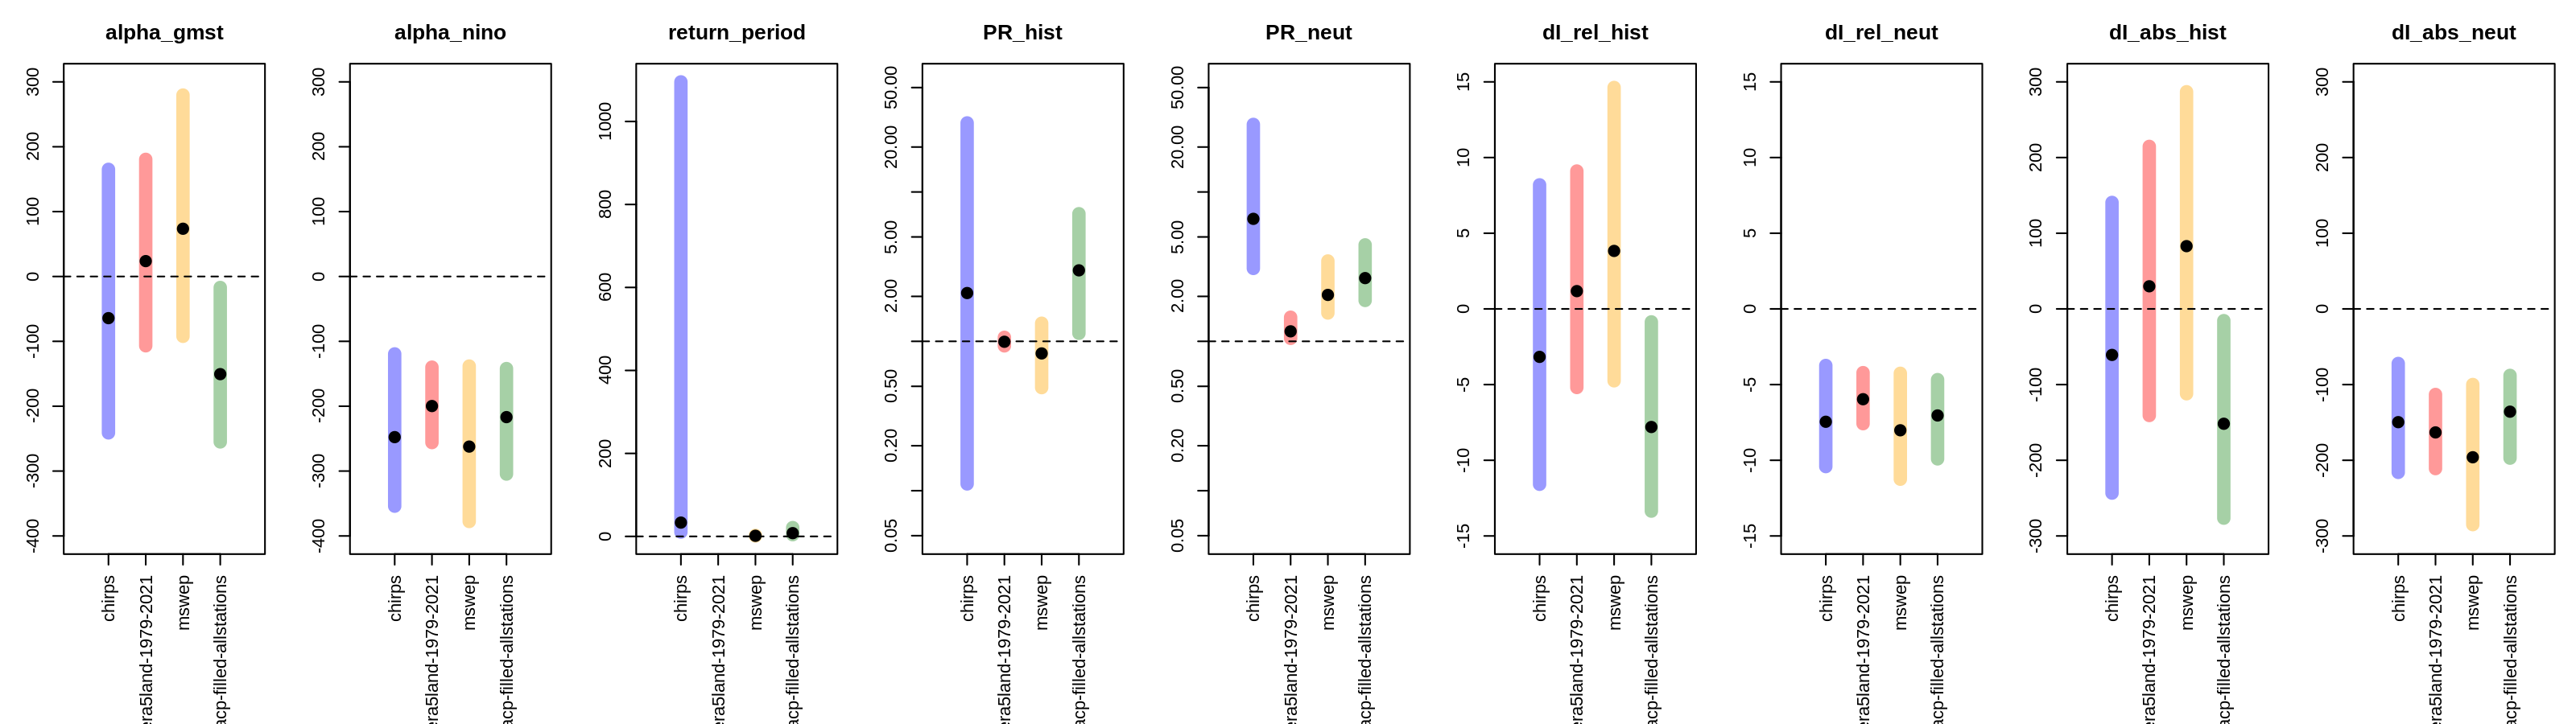

In [52]:
plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- res_rs[,r,]
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(res_rs[,grepl("alpha", colnames(res_rs)),]))
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(res_rs[,grepl("dI_abs", colnames(res_rs)),]))
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(res_rs[,grepl("dI_rel", colnames(res_rs)),]))
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(res_rs[,grepl("PR", colnames(res_rs)),]))))
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"X2.5."], y1 = res[,"X97.5."], lwd = 8, col = adjustcolor(c("blue", "red", "orange", "forestgreen", "chartreuse3", "chartreuse3"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

### Plots of fitted trends - length of station series (sensitivity analysis)

In [11]:
datasets <- c(1979, 1950, 1925, 1900, 1881)
nobs <- length(datasets)

# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [22]:
prep_window(c(1,nobs))
png("fig/sa_fitted-trend-stations.png", h = 480, w = 480*nobs); par(cex = 2, cex.main = 2.5, cex.lab = 2, cex.axis = 1.5); {
    par(mfrow = c(1,nobs), lwd = 2, mar = c(5.1, 5.1, 4.1, 2.1))
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_acp-filled-allstations-",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev <- NA } else { ev <- mdl$ev }

        plot(df$year+0.5, df$pr, type = "S", col = adjustcolor("black", 0.4), xlim = c(1881, 2023), ylim = c(1500,3500), xlab = "Year", ylab = "Rainy season precipitation (mm)", main = toupper(ds))
        lines(df$year, ns_pars(mdl)$loc, lwd = 2)
        lines(df$year, eff_return_level(mdl, 40), col = "blue", lwd = 2)
        points(2023, ev, pch = 0, col = "magenta", lwd = 2, cex = 3)
        
        # lines(df$year, fitted(loess(pr ~ year, df)), col = "red")
        
        legend("topleft", legend = c("Mean", "1-in-40-year event"), lty = 1, col = c("black", "blue"), lwd = 4, cex = 2)
    }
}; dev.off()

png 
  2

In [38]:
nsamp = 1000
prep_window(c(2,nobs))
png("fig/sa_covariate-trend-stations.png", h = 480*2, w = 480*nobs); par(cex = 2, cex.main = 2.5, cex.lab = 2, cex.axis = 1.5); {
    par(mfrow = c(2,nobs), lwd = 2, mar = c(5.1, 5.1, 4.1, 2.1))
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_acp-filled-allstations-",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev_x <- 9999 } else { ev_x <- NA }

        plot_covtrend(mdl, xcov = "gmst", main = toupper(ds), ci_cov = data.frame(gmst = c("now" = 0, "hist" = -1.2), nino = mean(df$nino)), nsamp = nsamp, ylim = c(1500,3500), ev_x = ev_x, ylab = "Rainy season precipitation (mm)")
    }
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_acp-filled-allstations-",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev_x <- 9999 } else { ev_x <- NA }

        plot_covtrend(mdl, xcov = "nino", ci_cov = data.frame(gmst = mean(df$gmst), nino = c("pos" = 1, "now" = cov_2023$nino, "neut" = 0)), nsamp = nsamp, main = toupper(ds), ylim = c(1500,3500), ev_x = ev_x, ylab = "Rainy season precipitation (mm)")
        abline(v = 0, lty = 2, lwd = 0.5)
    }
}; dev.off()

png 
  2

In [26]:
prep_window(c(1,nobs))
png("fig/sa_rl-plots-hist-stations.png", h = 480, w = 480*nobs); par(cex = 2, cex.main = 2.5, cex.lab = 2, cex.axis = 1.5); {
    par(mfrow = c(1,nobs), lwd = 2, mar = c(5.1, 5.1, 4.1, 2.1))
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_acp-filled-allstations-",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev <- NA } else { ev <- mdl$ev }

        plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop = F], ev <- ev, ylim = c(1000,3250), nsamp = 1000, main = toupper(ds), ylab = "Rainy season precipitation (mm)")
    }
}; dev.off()

png 
  2

In [27]:
prep_window(c(1,nobs))
png("fig/sa_rl-plots-neut-stations.png", h = 480, w = 480*nobs); par(cex = 2, cex.main = 2.5, cex.lab = 2, cex.axis = 1.5); {
    par(mfrow = c(1,nobs), lwd = 2, mar = c(5.1, 5.1, 4.1, 2.1))
    for (ds in datasets) {

        fnm <- paste0("ts/panama_pr-rs_acp-filled-allstations-",ds,".dat")

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        if(grepl("era5land", ds)) { ev <- NA } else { ev <- mdl$ev }

        plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["neut",,drop = F], ev <- ev, ylim = c(1000,3250), nsamp = 1000, main = toupper(ds), ylab = "Rainy season precipitation (mm)")
    }
}; dev.off()

png 
  2

#### Parameter estimates

In [16]:
# load all the bootstrapped results
res_rs <- abind::abind(sapply(datasets, function(ds) {
    read.csv(paste0("res/res_panama_pr-rs_acp-filled-allstations-",ds,".csv"), row.names = "X")
}, simplify = F), along = 0)
rownames(res_rs) <- datasets

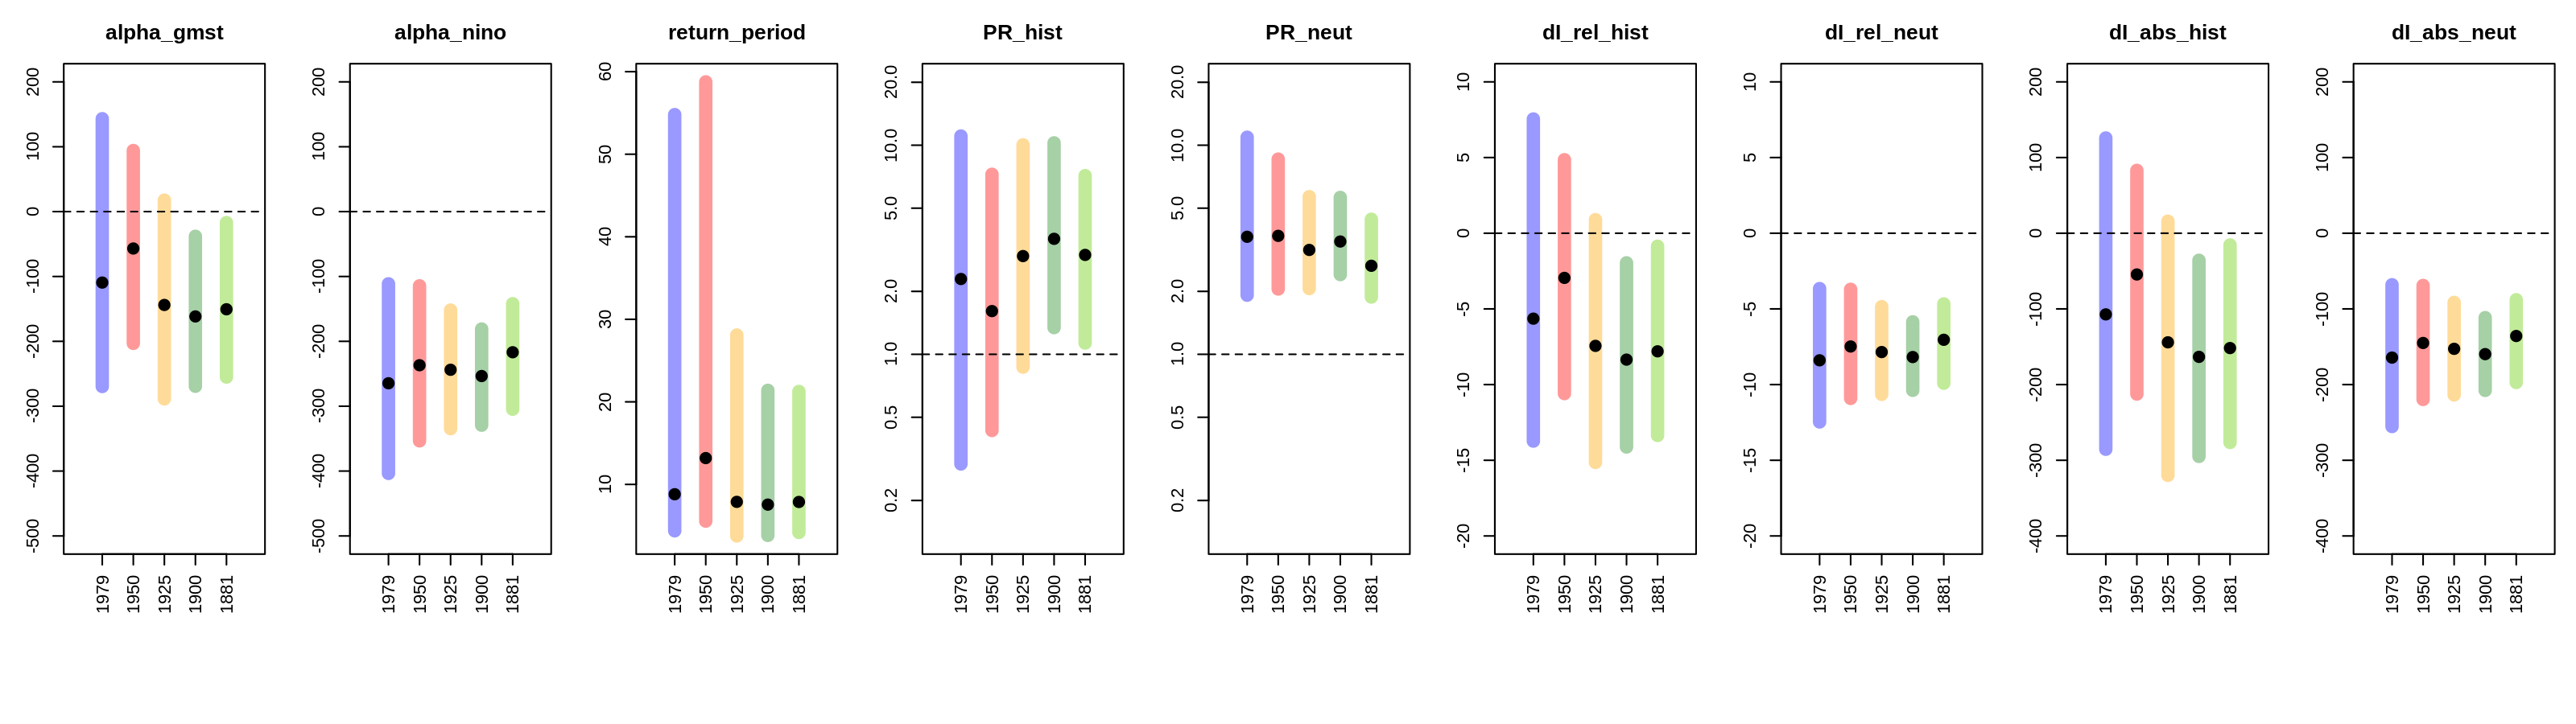

In [17]:
plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- res_rs[,r,]
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(res_rs[,grepl("alpha", colnames(res_rs)),]))
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(res_rs[,grepl("dI_abs", colnames(res_rs)),]))
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(res_rs[,grepl("dI_rel", colnames(res_rs)),]))
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(res_rs[,grepl("PR", colnames(res_rs)),]))))
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"X2.5."], y1 = res[,"X97.5."], lwd = 8, col = adjustcolor(c("blue", "red", "orange", "forestgreen", "chartreuse3", "chartreuse3"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

### Unconditional return periods

In [55]:
datasets <- c("chirps", "era5land-1979-2021", "mswep", "acp-filled-allstations")
nobs <- length(datasets)

# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [56]:
# fit all the models
nsamp <- 10
models <- sapply(datasets, function(ds) {
    fnm <- paste0("ts/panama_pr-rs_",ds,".dat")
    ts <- load_ts(fnm, col.names = c("year", "pr"))
    df <- merge(merge(gmst, nino), ts)
    fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
}, simplify = F)

In [57]:
# return period in neutral phase
round(sapply(models, function(mdl) c("RP 2024" = return_period(mdl, x = mdl$ev, fixed_cov = cov_2023),
                               "RP_neut" = return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F]),
                               "RP_unc" = 1/(mean(sapply(nino$nino[nino$year >= 1980], function(i) {
                                    1/return_period(mdl, x = mdl$ev, fixed_cov = data.frame("gmst" = gmst$gmst[gmst$year == 2023], "nino" = i))
                                }))))))

,chirps,era5land-1979-2021,mswep,acp-filled-allstations
RP 2024,33,1,2,8
RP_neut,220,1,3,21
RP_unc,63,1,3,15


## Dry season precip for comparison

In [54]:
datasets <- c("chirps", "era5land-1979-2021", "mswep", "acp-filled-allstations")

In [55]:
# load covariate data
nino <- load_ts("ts/panama_nino-ds.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [56]:
nsamp <- 1000
for (ds in datasets) {
    
    fnm <- paste0("ts/panama_pr-ds_",ds,".dat")
    
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        res <- boot_ci(mdl, cov_f = cov_2023, cov_cf = cov_cf, nsamp = nsamp)
        
        # get correlation between Nino3.4 and rainy season precip, for evaluation
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
                                                   
        write.csv(rbind(res, nino_corr), res_fnm)
    }
}

### Parameter estimates

In [59]:
# load all the bootstrapped results
res_ds <- abind::abind(sapply(datasets, function(ds) {
    read.csv(paste0("res/res_panama_pr-ds_",ds,".csv"), row.names = "X")
}, simplify = F), along = 0)
rownames(res_ds) <- datasets

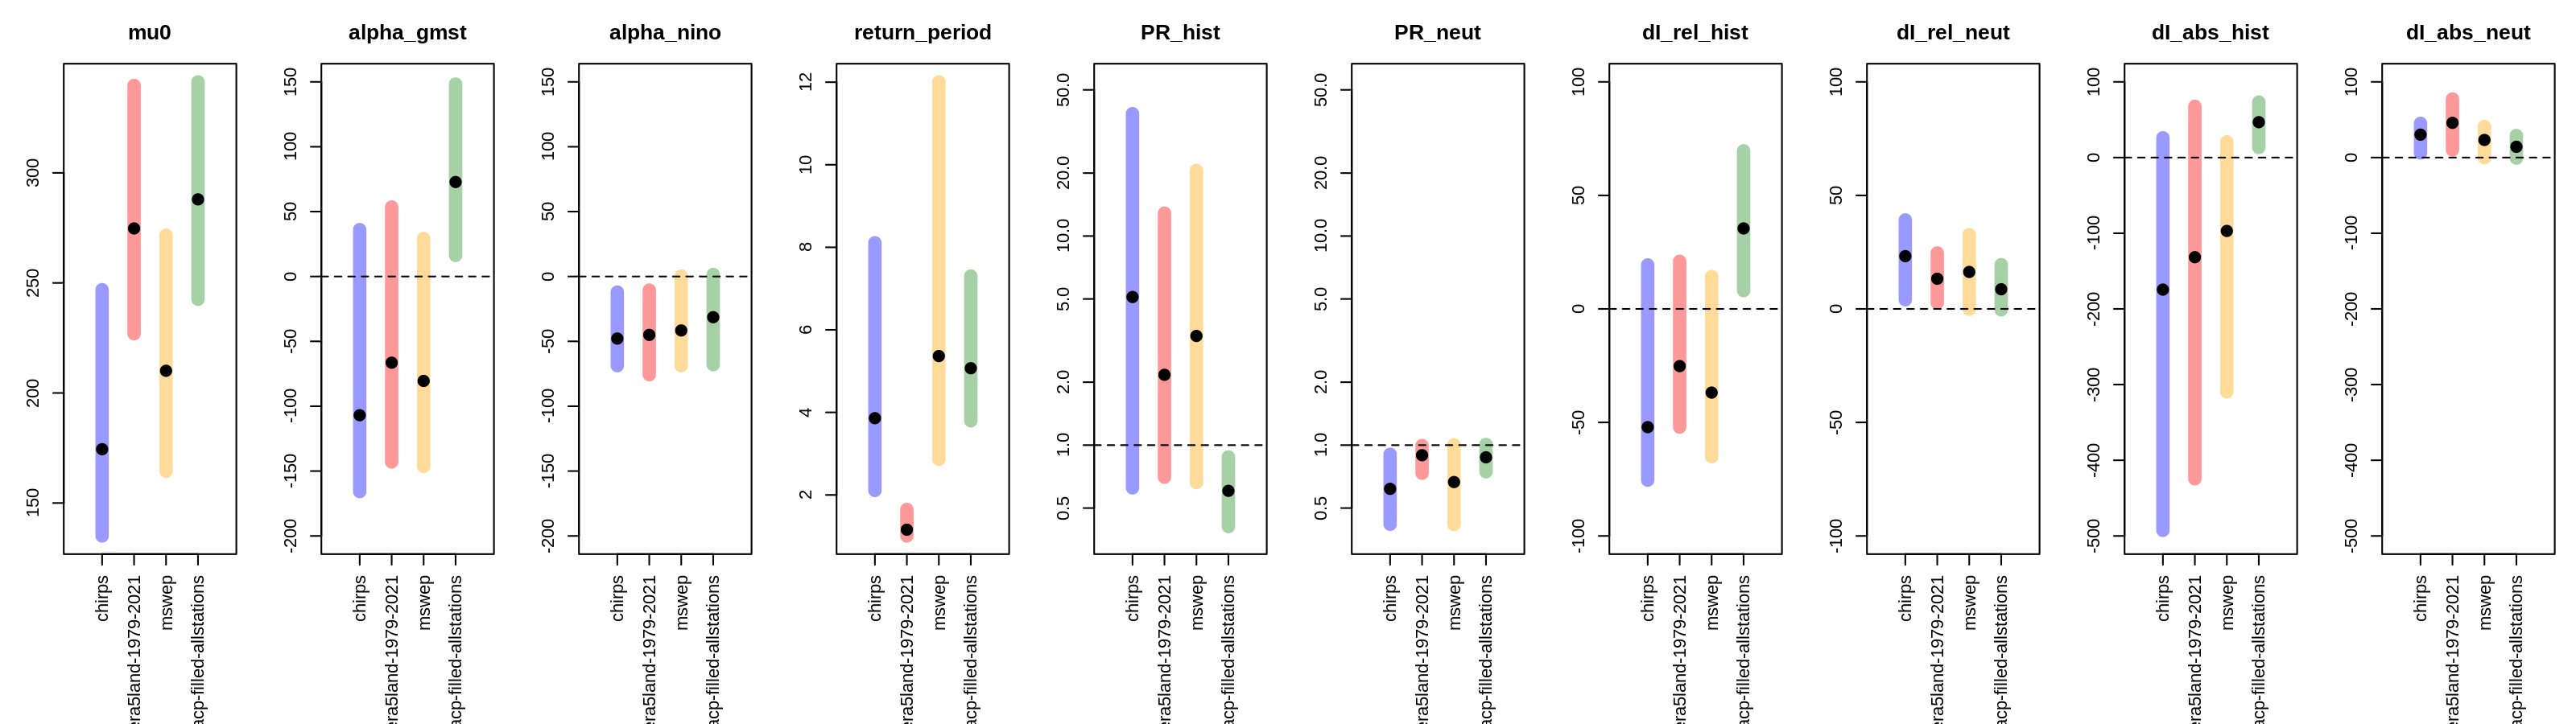

In [61]:
plot_pars <- c("mu0", "alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- res_ds[,r,]
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(res_ds[,grepl("alpha", colnames(res_ds)),]))
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(res_ds[,grepl("dI_abs", colnames(res_ds)),]))
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(res_ds[,grepl("dI_rel", colnames(res_ds)),]))
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(res_ds[,grepl("PR", colnames(res_ds)),]))))
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"X2.5."], y1 = res[,"X97.5."], lwd = 8, col = adjustcolor(c("blue", "red", "orange", "forestgreen", "chartreuse3", "chartreuse3"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

## Per grid cell

In [71]:
ds <- "mswep"

nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- read.csv(paste0("data/",ds,"_pr-rs_flattened.csv"), skip = 3, header = F)
colnames(df)[1] <- "year"

df <- merge(merge(nino, gmst), df)

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [72]:
# fit nonstationary model to all grid cells
models <- sapply(colnames(df)[-(1:3)], function(cnm) {
    df_c <- df[,c("year", "gmst", "nino", cnm)]
    fit_ns("norm", "fixeddisp", df_c, cnm, c("gmst", "nino"), lower = T)
}, simplify = F)

In [73]:
# get all model resuls & save as .csv to be reconstructed & plotted in python
fitted_res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
fitted_res <- rbind(fitted_res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(fitted_res, paste0("res/res_rs_",ds,"-gridded.csv"))

## Individual stations

In [2]:
# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

### Filled stations

In [3]:
# specify period to fit model to
ys <- 1979

# load station data, combine with covariates in single dataframe
pr <- read.csv("data/acp-filled_pr-rs.csv", row.names = "Date")
pr$year <- rownames(pr)
df <- merge(merge(gmst, nino), pr)

In [4]:
# fit all the models
models <- list()
for(stn in colnames(df)[-(1:3)]) {
    df_stn <- df[df$year >= ys,c("year", "gmst", "nino", stn)]
    models[[stn]] <- fit_ns("norm", "fixeddisp", df_stn, stn, c("gmst", "nino"), lower = T)
}

# get all the best estimates & save as single file
res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
res <- rbind(res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop = F])))
write.csv(res, paste0("res/res_rs_stations-filled_",ys,"-2023.csv"))

### Compare results when using subset with complete years vs gap-filled data

In [26]:
# load all the bootstrapped results
res_all <- abind::abind(sapply(list.files("res", pattern = "allstations-", full.names = T), read.csv, row.names = "X", simplify = F), along = 0)
rownames(res_all) <- paste(gsub(".csv", "", gsub(".+-", "", rownames(res_all))), "all")

res_subset <- abind::abind(sapply(list.files("res", pattern = "subset", full.names = T), read.csv, row.names = "X", simplify = F), along = 0)
rownames(res_subset) <- paste(gsub(".csv", "", gsub(".+-", "", rownames(res_subset))), "subset")

In [35]:
res_ds <- abind::abind(res_all, res_subset, rev.along = 0)

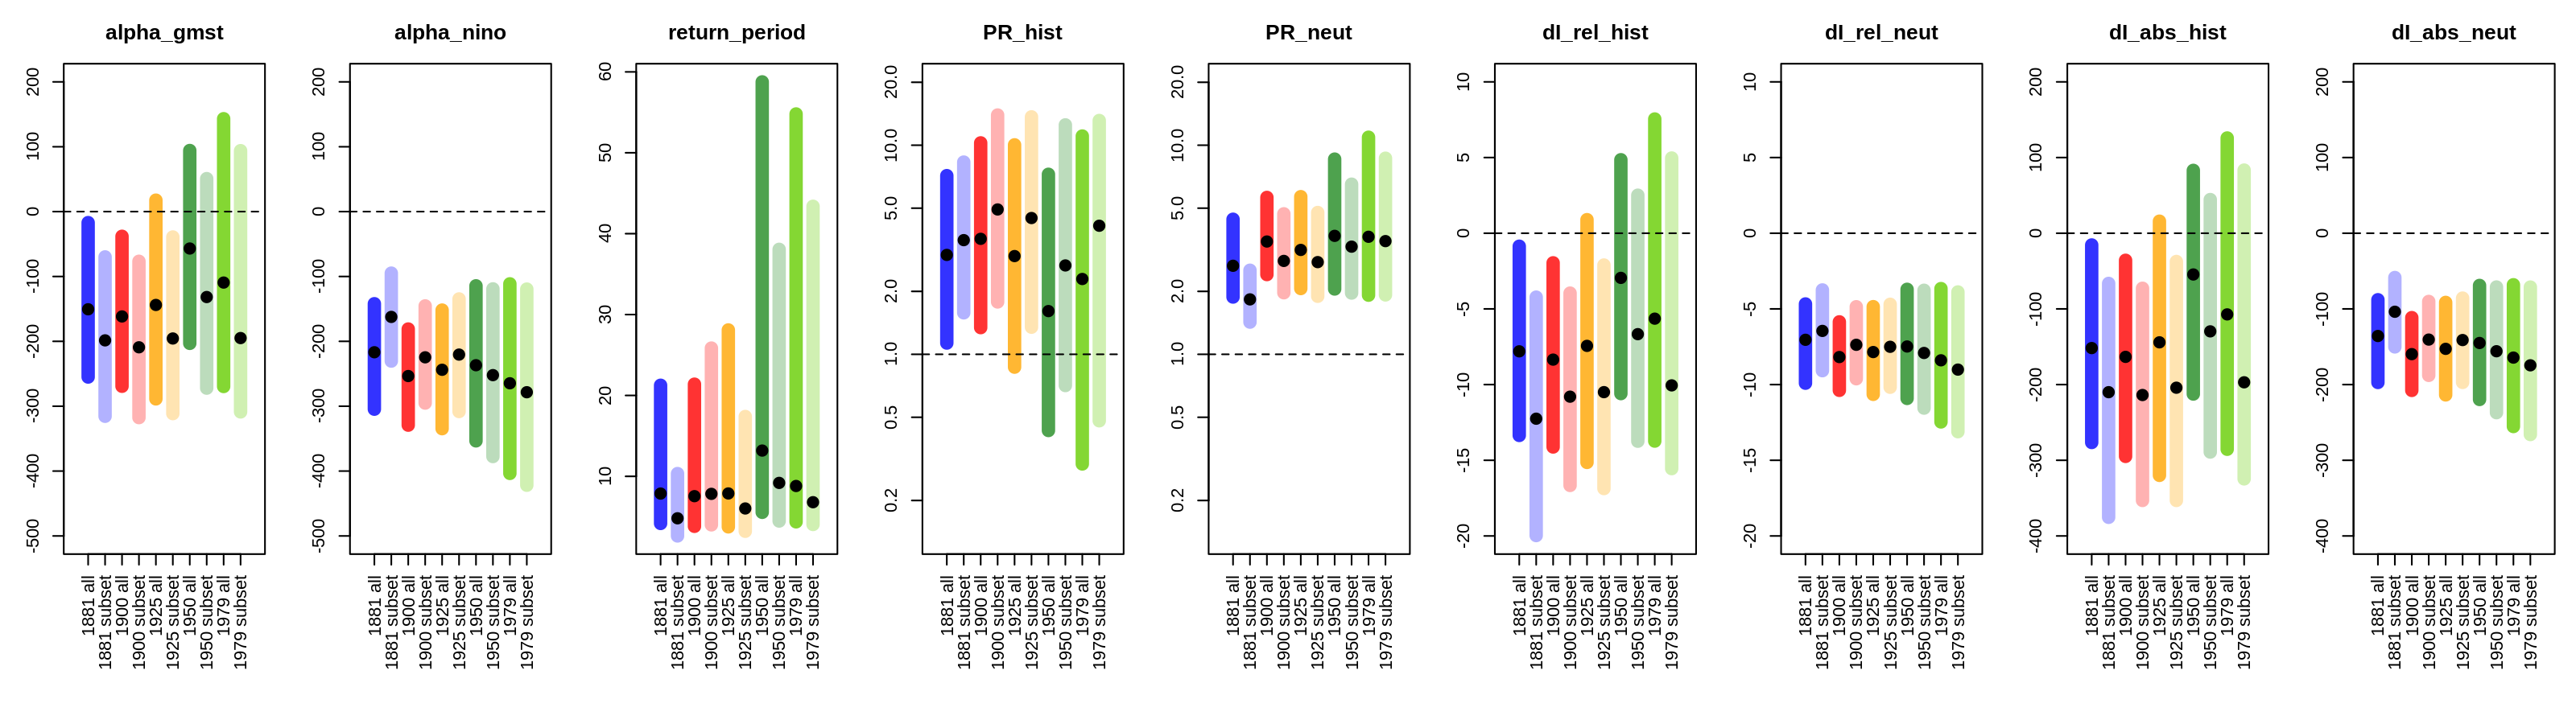

In [50]:
plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        
        res <- res <- rbind(res_all[,r,], res_subset[,r,])
        res <- res[order(rownames(res)),]
        
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(res_ds[,grepl("alpha", colnames(res_ds)),,]))
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(res_ds[,grepl("dI_abs", colnames(res_ds)),,]))
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(res_ds[,grepl("dI_rel", colnames(res_ds)),,]))
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(res_ds[,grepl("PR", colnames(res_ds)),,]))))
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"X2.5."], y1 = res[,"X97.5."], lwd = 8, col = mapply(adjustcolor, rep(c("blue", "red", "orange", "forestgreen", "chartreuse3"), each = 2), rep(c(0.8,0.3), 5)))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

In [19]:
ys <- 1979

res_complete <- read.csv(paste0("res/res_rs_stations-complete_",ys,"-2023.csv"), row.names = "X")
res_filled <- read.csv(paste0("res/res_rs_stations-filled_",ys,"-2023.csv"), row.names = "X")

# find stations that appear in both datasets, combine into a single array of all results
stations <- names(which(sapply(colnames(res_complete), function(cnm) cnm %in% colnames(res_filled))))
                               
res_all <- abind::abind("complete" = res_complete[,stations], "filled" = res_filled[,stations], along = 0)

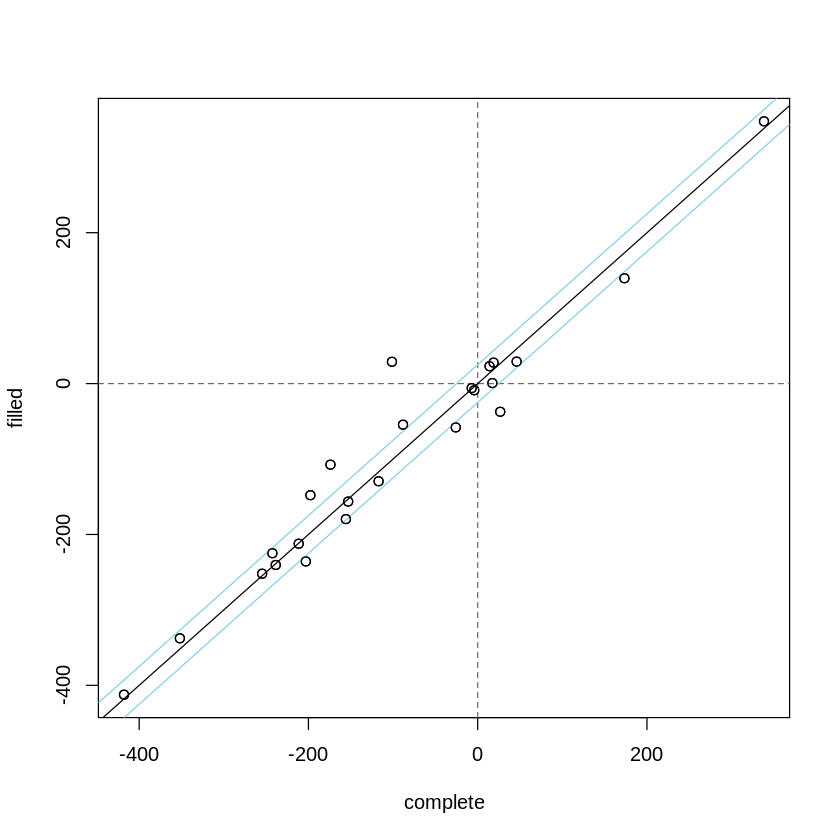

In [39]:
plot(t(res_all[,"alpha_gmst",]))
abline(h = 0, v = 0, lty = 2, col = "dimgrey")

abline(0,1); abline(25,1, col = "skyblue"); abline(-25,1, col = "skyblue")
points(t(res_all[,"alpha_gmst",]))

# Evaporation & evapotranspiration

## Gridded PET products

### Fit all models

In [56]:
seas <- "ds"

# load covariate data
nino <- load_ts(paste0("ts/panama_nino-",seas,".dat"), col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = data.frame("gmst" = -1.2, "nino" = cov_2023$nino),
                "neut" = data.frame("gmst" = 0, "nino" = 0))

In [76]:
nsamp <- 1000
datasets <- c("terraclimate", "era5land")

for (ds in datasets) {
    
    fnm <- paste0("data/pet-",seas,"_",ds,".csv")
    
    res_fnm <- gsub("data/", "res/res_", fnm)
    # if(!file.exists(res_fnm)) {
        
        ts <- read.csv(fnm, col.names = c("year", "pet"))
        df <- merge(merge(gmst, nino), ts)
        
        if(ds == "era5land") df <- df[df$year < 2022,]

        mdl <- fit_ns("norm", "shift", df, "pet", c("gmst", "nino"), lower = F)
        res <- boot_ci(mdl, cov_f = cov_2023, cov_cf = cov_cf, rp = 10, nsamp = nsamp)
        
        # get correlation between Nino3.4 and rainy season precip, for evaluation
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pet), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pet")])[1,2]), c(0.025, 0.975)))
                                                   
        write.csv(rbind(res, nino_corr), res_fnm)
    # }
}

### Compare parameter estimates

In [70]:
all_res <- abind::abind(sapply(list.files("res", pattern = "pet", full.names = T), read.csv, row.names = "X", simplify = F), along = 0)
rownames(all_res) <- gsub(".csv", "", gsub(".+pet-", "", rownames(all_res)))

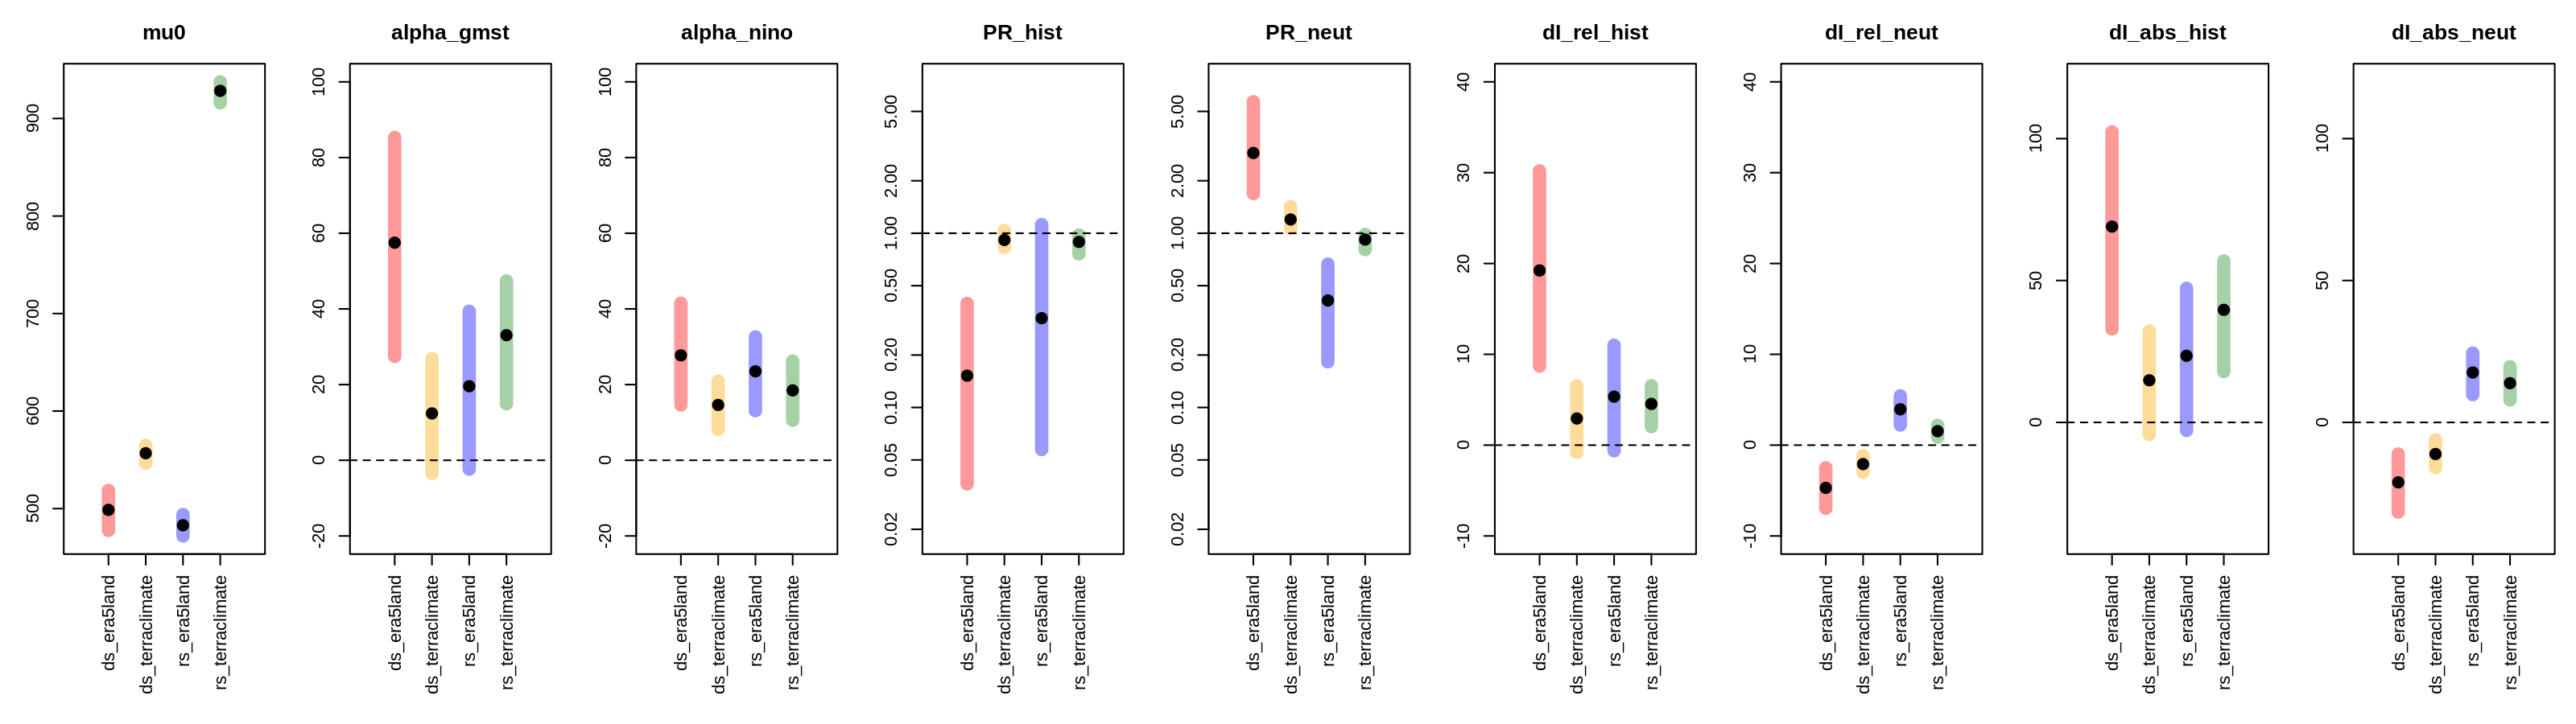

In [75]:
plot_pars <- c("mu0", "alpha_gmst", "alpha_nino", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,r,]
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,grepl("alpha", colnames(all_res)),]))
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(all_res[,grepl("dI_abs", colnames(all_res)),]))
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,grepl("dI_rel", colnames(all_res)),]))
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,grepl("PR", colnames(all_res)),]))))
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"X2.5."], y1 = res[,"X97.5."], lwd = 8, col = adjustcolor(c("red", "orange", "blue", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

## BCI pan study

In [18]:
df <- read.csv("data/panstudy.csv", skip = 4)
df$tascAM[!is.na(df$tasfAM)] <- (df$tasfAM[!is.na(df$tasfAM)] - 32) * 5/9

df$month <- as.integer(substr(df$date,1,2))
df$dryseason <- df$month <= 4

df$wspeed[df$wspeed > 450] <- NA # remove one very suspect value

df$warmday <- as.factor(df$tmax > 32.5)
df$tmax_warm <- df$tmax * (df$tmax > 32.5); df$tmax_warm[df$tmax_warm == 0] <- NA
df$tmax_cool <- df$tmax * (df$tmax <= 32.5); df$tmax_cool[df$tmax_cool == 0] <- NA

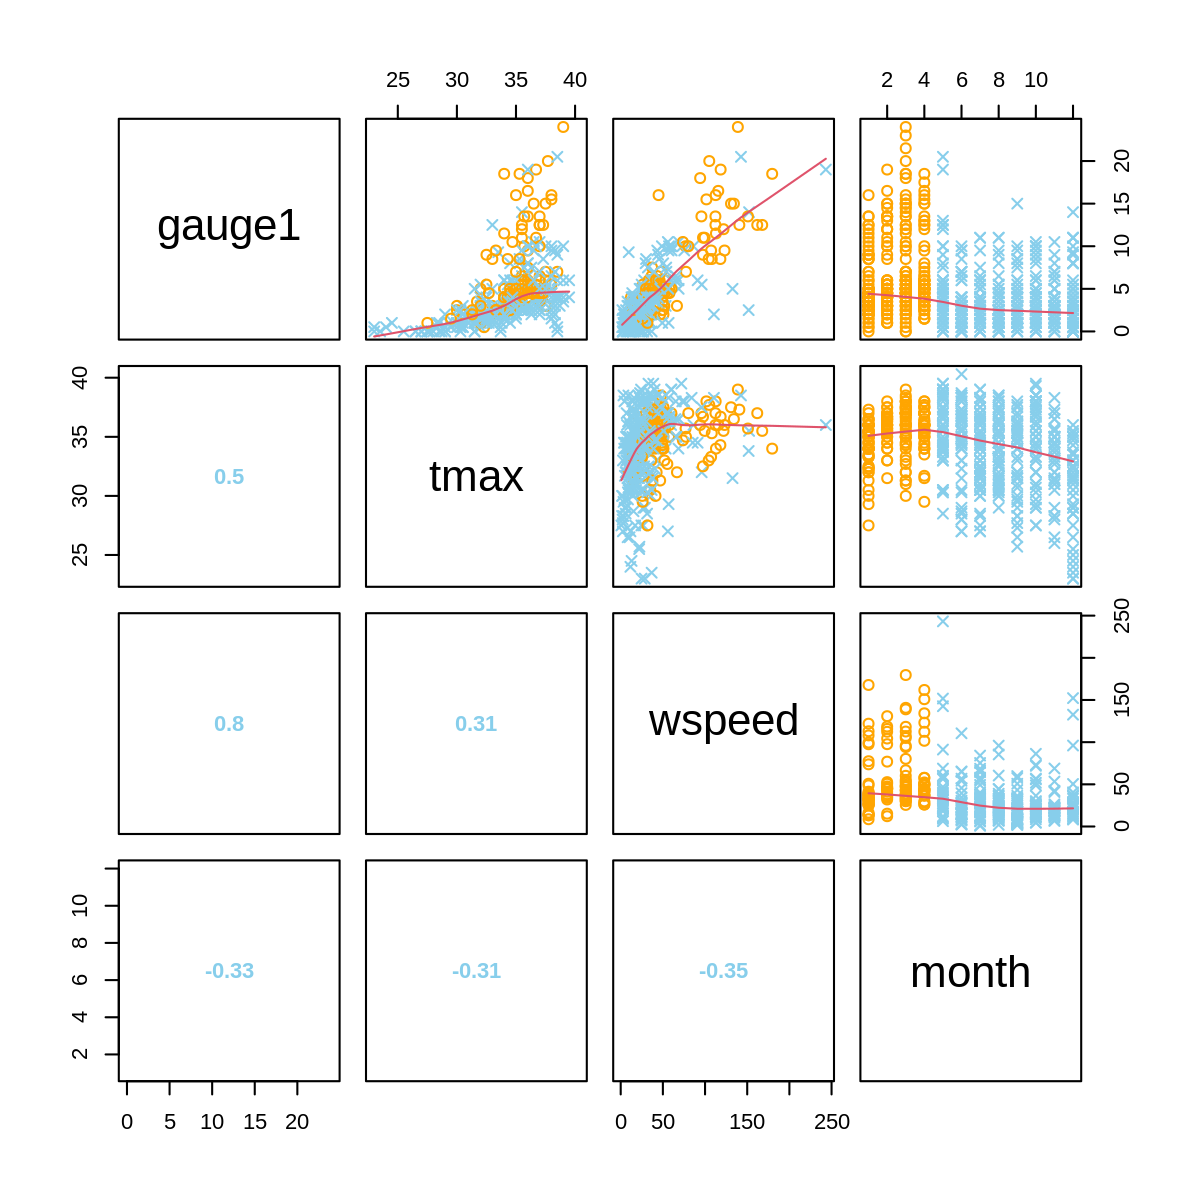

In [24]:
prep_window(c(1,1), h = 6, w = 6)
pairs(df[,c("gauge1", "tmax", "wspeed", "month")], lower.panel = panel.cor, upper.panel = panel.smooth, col = c("skyblue", "orange")[df$dryseason+1], pch = c(4,1)[df$dryseason+1])

---
# Trend fitting - climate models

## GMST + Nino3.4

In [48]:
rp = 20
nsamp = 1000

# standardise Nino to have mean 0 and sd 1 over 1979-2023
nino_obs <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
nino_1979 <- nino_obs$nino[nino_obs$year >= 1979]
nino_obs$nino <- (nino_obs$nino - mean(nino_1979)) / sd(nino_1979)

# use 2023 standardised Nino as covariate
nino_2023 <- nino_obs$nino[nino_obs$year == 2023]

# currently no Nino data for EC-EARTH
fl <- list.files("ts", pattern = "rs_.AM-[0-9]{2}", full.names = T)
fl <- fl[!grepl("EC-EARTH", fl)]

In [59]:
for (fnm in fl) {
    
    # skip models with known data issues
    if(fnm %in% c('ts/panama_pr-rs_SAM-44_CanESM2_r1i1p1_WRF341I.dat')) next
    
    nino_fnm <- list.files("ts", pattern = paste0("nino-rs_", paste0(strsplit(fnm, "_")[[1]][4:5], collapse = "_")), full.names = T)
    if(length(nino_fnm) == 0) next

    # load data & fit model
    ts <- load_ts(fnm, col.names = c("year", "pr"))
    gmst <- load_ts(list.files("ts", pattern = paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][4]), full.names = T), col.names = c("year", "gmst"))
    nino <- load_ts(nino_fnm, col.names = c("year", "nino"))
    
    # combine all covariates with time series
    df <- merge(ts, merge(gmst, nino))
    
    mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)

    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/", fnm))
    if(!file.exists(res_fnm)) {
        
        # use model's 2023 GMST & observed Nino to define factual climate
        gmst_2023 <- df$gmst[df$year == 2023]
        
        cov_2023 <- data.frame(gmst = gmst_2023, nino = nino_2023)
        cov_cf <- rbind("pi" = data.frame("gmst" = gmst_2023 - 1.2, "nino" = nino_2023), 
                        "neut" = data.frame("gmst" = gmst_2023, "nino" = 0))
        cov_fut <- data.frame(gmst = gmst_2023 + 0.8, nino = nino_2023)

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_2023, cov_hist = cov_cf, cov_fut = cov_fut,
                             y_now = 2023, y_start = 1979, y_fut = 2050, nsamp = nsamp)
        
        # bootstrap correlation between Nino & precip in this region
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), 
                       quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
        nino_corr <- setNames(data.frame(t(nino_corr)), paste0("nino-corr_", c("est", "lower", "upper")))
                                       
        res <- cbind(nino_corr, res)
        write.csv(res, res_fnm)
    }
                                       
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 480, w = 480 * 2); par(cex.main = 1.4, mfrow = c(1,2), oma = c(0,0,2,0)); {
            plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["pi",,drop = F], nsamp = 100, main = "Present vs PI")
            plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["neut",,drop = F], nsamp = 100, main ="Present vs neutral Nino3.4")
            mtext(outer = T, gsub(".dat","",paste0(strsplit(fnm, "_")[[1]][4:6], collapse = "_")), font = 2, cex = 1.5)
        }; dev.off()
    }
}

In [60]:
# compile results
res <- t(sapply(list.files("res", pattern = "pr-rs_.AM-[0-9]{2}", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", paste0(strsplit(rnm, "_")[[1]][3:6], collapse = "_")))
write.csv(res, "res_pr-rs_gmst-nino_cordex.csv")